## Standard GAN
* The dataset can be found here: https://www.kaggle.com/sachinpatel21/az-handwritten-alphabets-in-csv-format 

### Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import (Dropout, Input, Dense, Conv2D, 
                          MaxPooling2D, GlobalAveragePooling2D, 
                          UpSampling2D, Conv2DTranspose, 
                          Reshape, Flatten, Activation, 
                          BatchNormalization)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam

### Quick data preprocessing

In [ ]:
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

data = pd.read_csv("/content/emnist-byclass-test.csv").astype('float32')
df = pd.DataFrame(data)
arr = df.to_numpy()
selected_data = []
data_label = []
total = 62*100
count = 0
num_elements = 0
# print(df['18'])
for i in range(0, 62):
    # num_elements = 0
    # while num_elements != 100:
        for num in range(len(df['18'])):
            # if num_elements == 100:
            #     break
            if df['18'][num] == i:

                # print("hiiiiiiiiiiiii", arr[num][1:])
                data_label.append(arr[num][0])
                # print("hiiiiii", arr[num][0])
                # print("check this out ", data_label)
                selected_data.append(arr[num][1:])
                # num_elements += 1
                count += 1
                # print("num element is", num_elements)
                print("total process is: ", count/total*100, "%")
print("the conversion is finished")
label = np.array(data_label)
data = np.array(selected_data)

In [ ]:
width, height, channel = 28, 28, 1

In [ ]:
# X = data.iloc[:,1:].values
X = data
X = X.reshape((116322, width, height))
np.random.shuffle(X)
print(len(X))
# X.shape

116322


In [ ]:
X = (X - 127.5) / 127.5

### Visualize the data

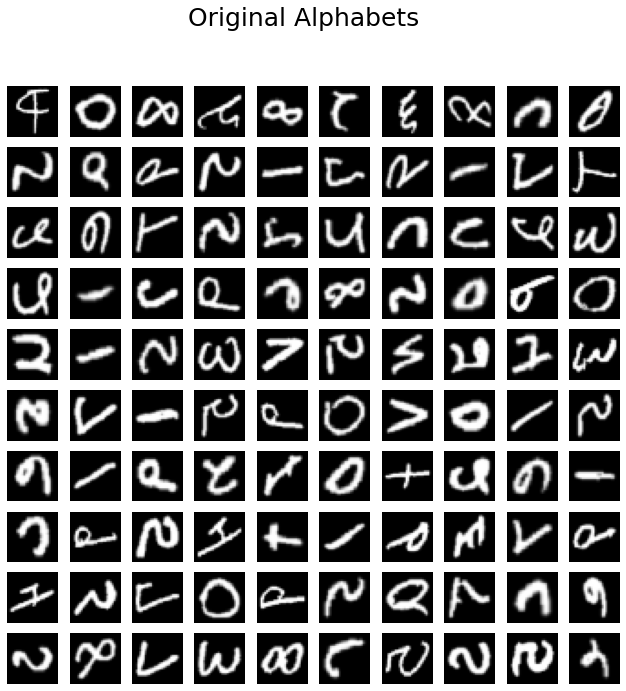

In [ ]:
def show_data(X, title=""):
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in X:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height, width)), cmap='gray')
        plt.axis('off')
        i+=1
        if i>100: break

    plt.suptitle(title, fontsize = 25)
    plt.show()
    
show_data(X, title="Original Alphabets")

In [ ]:
gen_optimizer = Adam(0.0001, 0.5)
disc_optimizer = Adam(0.0002, 0.5)
noise_dim = 100

### Start building GAN

In [ ]:
def buildGenerator():
    model = Sequential()

    model.add(Dense(1024, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Dense(6272, input_dim=noise_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    model.add(Reshape((7, 7, 128)))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (2, 2), padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(channel, (3, 3), padding='same', activation = "tanh", 
                     kernel_initializer=RandomNormal(0, 0.02)))
    
    return model

In [ ]:
generator = buildGenerator()
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              103424    
                                                                 
 batch_normalization_9 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 6272)              6428800   
                                                                 
 batch_normalization_10 (Bat  (None, 6272)             25088     
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 6272)             

In [ ]:
def buildDiscriminator():
    model = Sequential()
    
    model.add(Conv2D(64, (5, 5), strides=2, padding='same', 
                     kernel_initializer=RandomNormal(0, 0.02), 
                     input_shape=(width, height, channel)))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, (5, 5), strides=2, 
                     kernel_initializer=RandomNormal(0, 0.02)))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=disc_optimizer)
    return model

In [ ]:
discriminator = buildDiscriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 5, 5, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 3200)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               819456    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 256)              

In [ ]:
noise = Input(shape=(noise_dim,))
fake_data = generator(noise)
discriminator.trainable = False
output = discriminator(fake_data)
gan = Model(noise, output)
gan.compile(loss='binary_crossentropy', optimizer=gen_optimizer)

In [ ]:
gan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_6 (Sequential)   (None, 28, 28, 1)         6595073   
                                                                 
 sequential_7 (Sequential)   (None, 1)                 1026305   
                                                                 
Total params: 7,621,378
Trainable params: 6,580,353
Non-trainable params: 1,041,025
_________________________________________________________________


In [ ]:
def show_generated_alphabets(title, epoch):
    imgs = generator.predict(fixed_noise)
    imgs = 0.5 * imgs + 0.5
    plt.figure(figsize=(11,11))
    
    i = 1
    for img in imgs:
        plt.subplot(10, 10, i)
        plt.imshow(img.reshape((height,width)), cmap='gray')
        plt.axis('off')
        i+=1
    plt.suptitle(title, fontsize = 25)
    plt.savefig(str(epoch)+".png", transparent=True)
    plt.show()

In [ ]:
epochs = 81
batch_size = 128
steps_per_epoch = len(X)//batch_size

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        input_gen = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_data = generator.predict(input_gen)
        
        real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
        real_data = real_data.reshape((batch_size, width, height, channel))
        
        input_disc = np.concatenate((real_data, fake_data))

        label_disc = np.zeros(2*batch_size)
        label_disc[:batch_size] = 0.9
        label_disc[batch_size:] = 0.1
        loss_disc = discriminator.train_on_batch(input_disc, label_disc)

        label_gen = np.ones(batch_size)
        loss_gen = gan.train_on_batch(input_gen, label_gen)

    print("epoch: ", epoch)
    print("discriminator loss: ", loss_disc)
    print("generator loss: ", loss_gen)
    print("-"*80)
    
    if epoch % 5 == 0:
        show_generated_alphabets("Generated Alphabets", epoch)

In [ ]:
generator.save('cGAN.h5')

In [ ]:
from keras.models import load_model

In [ ]:
M = load_model('cGAN.h5')

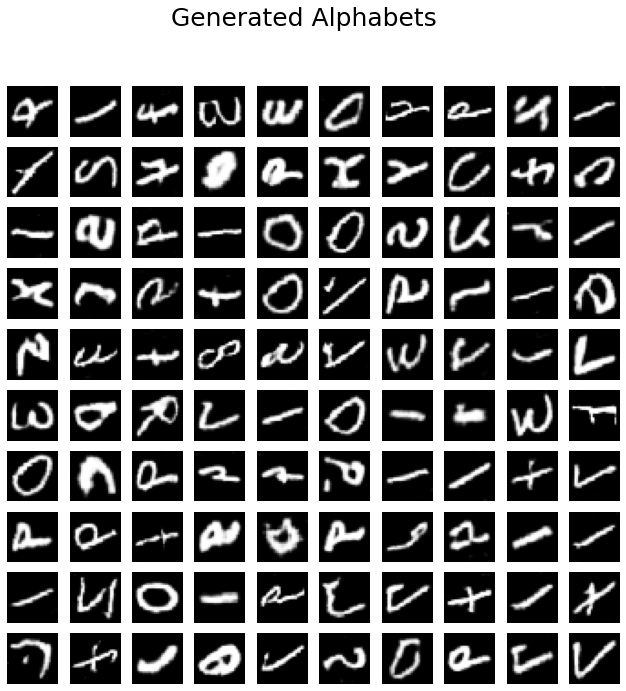

In [ ]:
fixed_noise = np.random.normal(0, 1, size=(100, noise_dim))
input_gen = np.random.normal(0, 1, size=(batch_size, 100))
fake_data = M.predict(input_gen)

real_data = X[np.random.randint(0, X.shape[0], size=batch_size)]
real_data = real_data.reshape((batch_size, width, height, channel))

input_disc = np.concatenate((real_data, fake_data))

label_disc = np.zeros(2*batch_size)
label_disc[:batch_size] = 0.9
label_disc[batch_size:] = 0.1
loss_disc = discriminator.train_on_batch(input_disc, label_disc)

label_gen = np.ones(batch_size)
loss_gen = gan.train_on_batch(input_gen, label_gen)
show_generated_alphabets("Generated Alphabets", 80)

## More Complex GANs (cGANs)
* Implemented to roughly represent the StyledFontGAN (Discriminator and generator architectures are outlined below)
* Discriminator
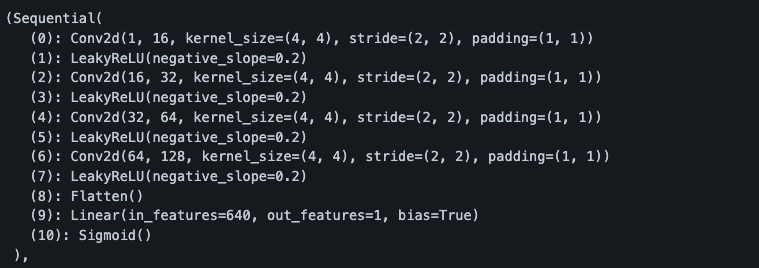
* Generator Architecture:
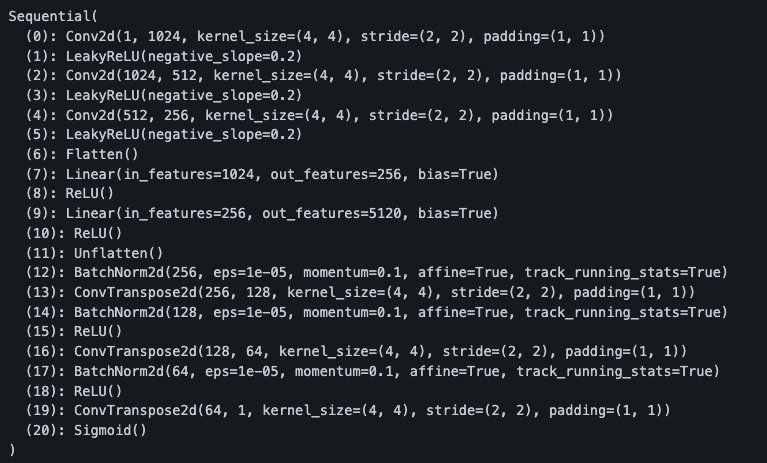


### Full description of architecture of cGANs can be found here: https://github.com/joshpc/StyledFontGAN

In [ ]:
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(n_nodes))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    model.summary()
    return model

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape, name='discriminator_1'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape, name='discriminator_2'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dense(6272))
    model.add(ReLU())
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape, name='discriminator_x'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape, name='discriminator_y'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Pix2Pix Attempted Implementation (Didn't finish)
* Followed the official TensorFlow turotial: https://www.tensorflow.org/tutorials/generative/pix2pix   
The diagram for Pix2Pix generator architecture 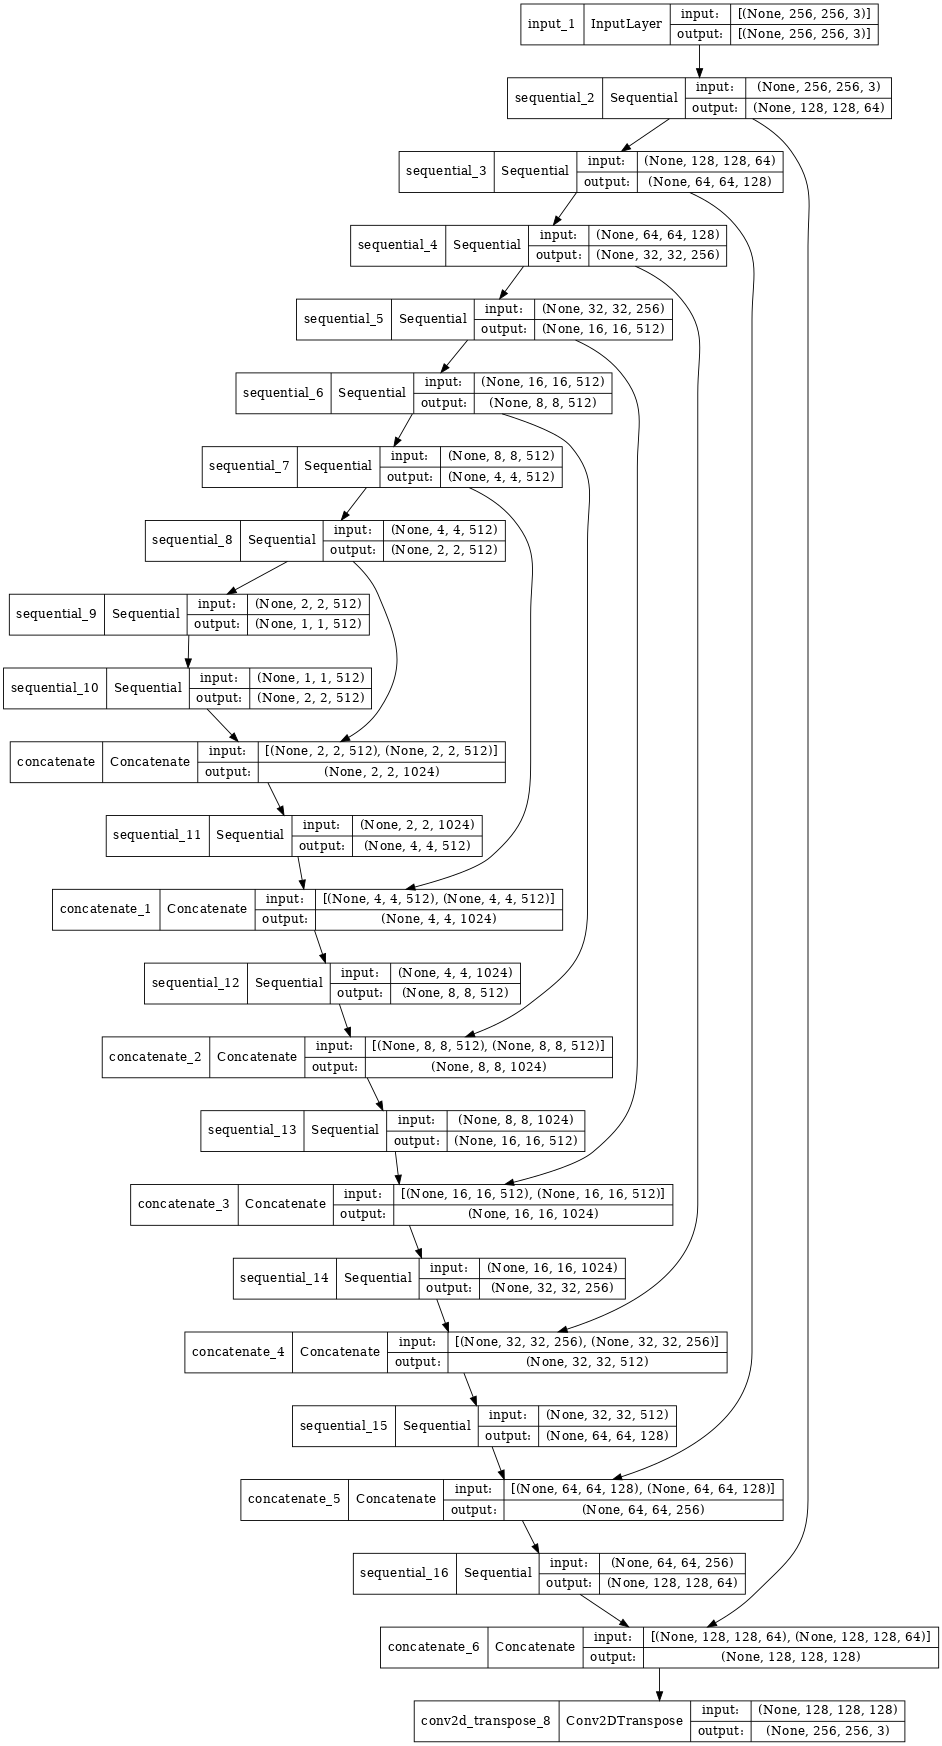

In [ ]:
 def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Discriminator  
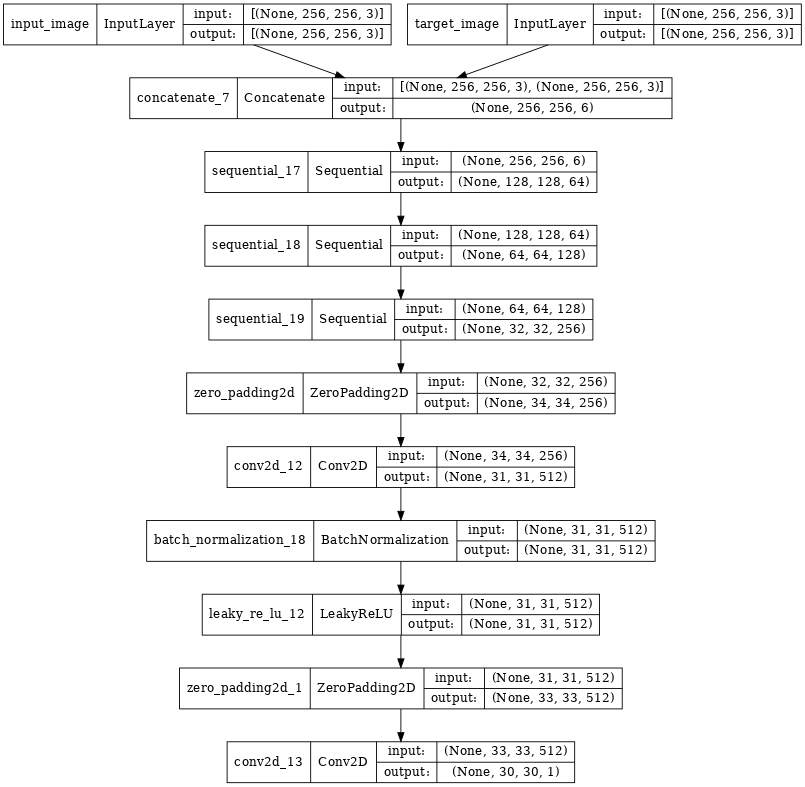

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

## Future Improvements (Other GANs to try)
* Auxiliary Classifier GAN
* Multi-Content GAN 

## Two ways to calcualte similarity between images
1. Using MSE
2. Using DeepAI Image Similarity API

In [ ]:
# 1. Using MSE
def MeanSquareError(image1, image2):
    error = (np.sum((image1.astype("float") - image2.astype("float")) **2)) / float(image1.shape[0]) / float(image1.shape[1])
    return error

In [ ]:
# 2. Using DeepAI Image Similarity API
import requests
r = requests.post(
    "https://api.deepai.org/api/image-similarity",
    files={
        'image1': open('/path/to/your/file.jpg', 'rb'),
        'image2': open('/path/to/your/file.jpg', 'rb'),
    },
    headers={'api-key': 'quickstart-QUdJIGlzIGNvbWluZy4uLi4K'}
)
print(r.json())